# Global Imports

In [90]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict
from collections import Counter
random.seed(42)

# Local Imports

In [91]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [92]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Indigo"
LOAD_CHECKPOINT: str = r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch40_trainacc0.73697_valacc0.95283_Tloss0.059694_Vloss0.012153_lr0.0007224999999999999.pkl"

# Define Paths
Workspace

In [93]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [94]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-f]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)

len(image_paths)

1092

# Helper Functions

In [95]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [96]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels From File Names

In [97]:


labeled_image_paths: list[tuple[str, str]] = []

class_counts: dict[str, int] = defaultdict(lambda: 0)

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    
    class_counts[u_hexvalue] += 1
    
    
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))

len(labels), len(image_paths)

(1092, 1092)

In [98]:
Counter(labels)

Counter({'u31': 54,
         'u2b': 54,
         'u61': 54,
         'u3bb': 49,
         'u2e': 49,
         'u28': 48,
         'u29': 48,
         'ud7': 22,
         'u33': 20,
         'u36': 20,
         'u6e': 20,
         'u37': 20,
         'u6f': 20,
         'u75': 20,
         'u69': 20,
         'u70': 20,
         'u6d': 20,
         'u64': 20,
         'u72': 20,
         'u6c': 20,
         'u77': 20,
         'u35': 20,
         'u38': 20,
         'u67': 20,
         'u76': 20,
         'u66': 20,
         'u32': 20,
         'u6a': 20,
         'u65': 20,
         'u73': 20,
         'u34': 20,
         'u79': 20,
         'u62': 20,
         'u39': 20,
         'u6b': 20,
         'u71': 20,
         'u30': 20,
         'u74': 20,
         'u63': 20,
         'u68': 20,
         'u7a': 20,
         'u78': 20,
         'uf7': 17,
         'u2d': 17})

# Balance Classes Using Oversample/Undersample

In [99]:
sorted_counts: list[tuple[str, int]] = sorted(
    class_counts.items(), 
    key=lambda x: x[0]
)

counts: list[int] = [pair[1] for pair in sorted_counts]

max_count: int = max(counts)
min_count: int = min(counts)

to_add_counts: dict[str, int] = {
    uid: max_count - count 
    for uid, count in 
    sorted_counts
}

to_undersample_counts: dict[str, int] = {
    uid: min_count
    for uid, count in 
    sorted_counts
}

total_items = sum(x[1] for x in sorted_counts)


In [100]:
min_count, max_count, total_items

(17, 54, 1092)

In [53]:
#print(*to_add_counts.items())
#print(sorted([(chr(int(pair[0][1:], 16)), pair[1]) for pair in to_remove_counts.items()], key=lambda x: x[1]))

# Oversample

In [54]:
#to_add_labels: list[str] = []
#to_add_file_paths: list[str] = []
#
#while True in [to_add_count>0 for to_add_count in to_add_counts.values()]:  
#    for label, image_path in zip(labels, image_paths):
#        remaining: int = to_add_counts[label]
#        
#        if remaining > 0:
#            to_add_labels.append(label)
#            to_add_file_paths.append(image_path)
#            to_add_counts[label] -= 1

# Undersample

In [101]:
to_keep_labels: list[str] = []
to_keep_file_paths: list[str] = []

while True in [to_add_count>0 for to_add_count in to_undersample_counts.values()]:  
    for label, image_path in zip(labels, image_paths):
        remaining: int = to_undersample_counts[label]
        
        if remaining > 0:
            to_keep_labels.append(label)
            to_keep_file_paths.append(image_path)
            to_undersample_counts[label] -= 1

In [102]:

Counter(to_keep_labels)

Counter({'u3bb': 17,
         'u33': 17,
         'u31': 17,
         'u36': 17,
         'u6e': 17,
         'u28': 17,
         'u37': 17,
         'u6f': 17,
         'u29': 17,
         'u75': 17,
         'u69': 17,
         'u70': 17,
         'u6d': 17,
         'u2b': 17,
         'u64': 17,
         'u72': 17,
         'uf7': 17,
         'u6c': 17,
         'u2d': 17,
         'u77': 17,
         'u35': 17,
         'u38': 17,
         'u67': 17,
         'u76': 17,
         'u2e': 17,
         'u66': 17,
         'u61': 17,
         'u32': 17,
         'u6a': 17,
         'u65': 17,
         'u73': 17,
         'u34': 17,
         'u79': 17,
         'u62': 17,
         'u39': 17,
         'u6b': 17,
         'u71': 17,
         'u30': 17,
         'u74': 17,
         'u63': 17,
         'ud7': 17,
         'u68': 17,
         'u7a': 17,
         'u78': 17})

# Load Dataset

In [103]:
image_paths = to_keep_file_paths
labels = to_keep_labels
len(image_paths), len(labels)

(748, 748)

In [104]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = sorted(list(set(labels)))

In [105]:

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index], #list(image_paths[:split_index]) + to_add_file_paths,
    labels=labels[:split_index], #list(labels[:split_index]) + to_add_labels,
    all_label_classes=all_label_classes,
    rotation_limit=0.02,
    translation_limit=0.2,
    skew_limit=0.06,
    zoom_change=1.0,
    min_zoom=0.8,
    thicken_sigma=1.75,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    min_zoom=1.0,
    thicken_sigma=0.0,
    image_dims=(64, 64)
)




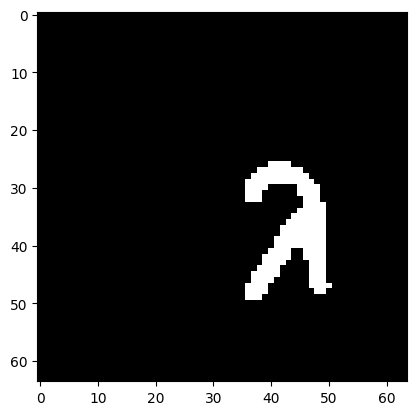

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [116]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    break

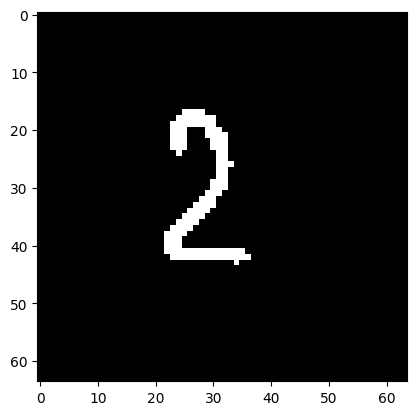

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])


In [119]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [120]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

In [121]:
len(class_counts.keys())

44

# Define Model Hyperparameters

In [122]:


all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": LOAD_CHECKPOINT
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.0007224,
        "weight_decay": 0.000001
    }
]


In [78]:
len(val_dataloader)

7

# Train

In [123]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        
        train_is_correct = y_hat_pred==y_pred
        train_correct_tally += torch.sum(train_is_correct)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()
        print(y_hat_pred, y_pred)
        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 39, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 39, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 39, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 16, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 32, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 39]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 39, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 39, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 39, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([10, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40, 30, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27,  0, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19,  7]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31,  2, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Validating Model...: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41]) tensor([ 7, 22, 32, 39, 27, 27, 31, 42, 40, 18, 38, 23, 41, 21, 19, 41])
tensor([38, 18, 13, 23, 31, 19, 33, 26,  2, 35, 38, 28,  8, 29, 17, 27]) tensor([38, 18, 13, 23, 31, 19, 33, 26, 42, 35, 38, 28,  8, 29, 17, 27])
tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31]) tensor([19, 34,  5,  7, 30,  3, 39, 23, 41, 26, 25, 30, 33, 12, 11, 31])
tensor([40, 30, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9]) tensor([40,  5, 31, 30, 27, 17, 22, 43, 37, 43, 42, 31, 37, 36, 30,  9])
tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41, 30]) tensor([26, 13, 22, 22, 42, 26, 13, 33, 14, 23, 34, 29, 18, 18, 41,  5])
tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38]) tensor([34, 23, 43, 39,  9, 40,  5, 32,  5, 17, 19,  9, 37,  5, 14, 38])
tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41, 26, 36,  8, 34, 36]) tensor([22, 38,  8, 24, 41, 35, 39, 14, 17, 28, 41,

Training model...:  11%|█         | 4/38 [00:03<00:32,  1.05it/s]


KeyboardInterrupt: 

# Inference

In [126]:
model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.0,#0.075,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": r"C:\Users\Leon\visual-studio\repos\Le-o-n\ocr-model-training\models\allcnn\Indigo_epoch26_trainacc0.71327_valacc0.99057_Tloss0.072851_Vloss0.0056362_lr0.0007224999999999999.pkl"
    }
)

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

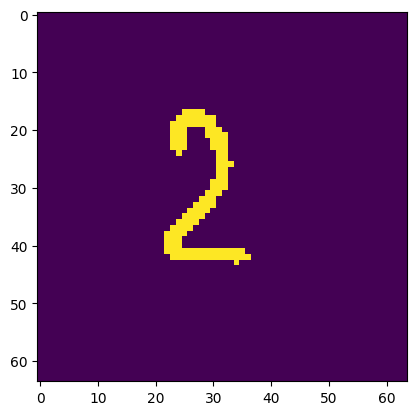

2


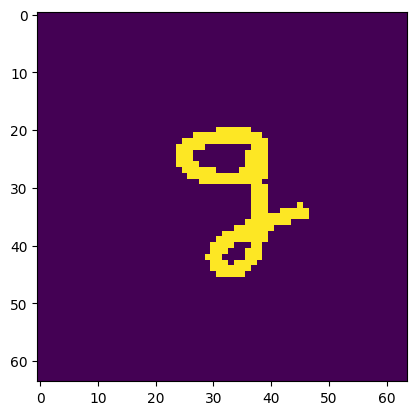

q


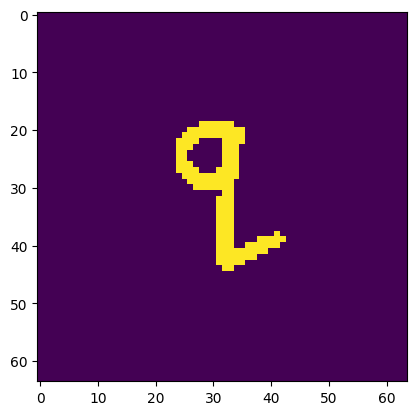

q


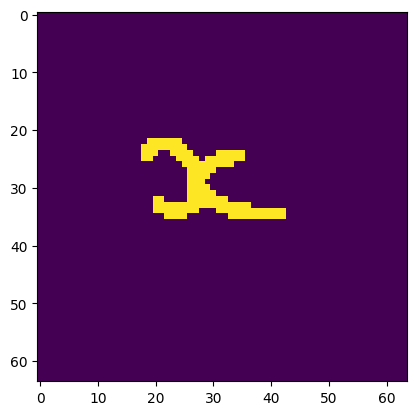

×


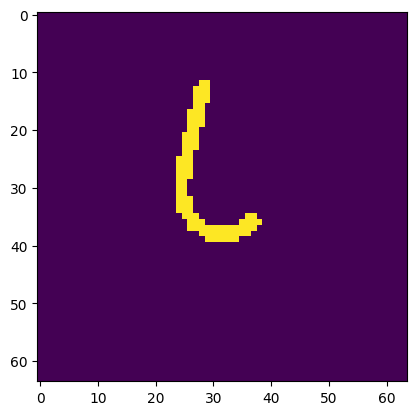

l


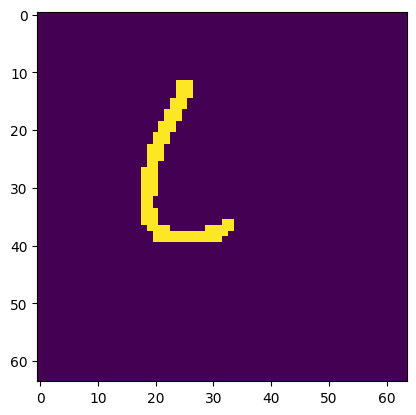

l


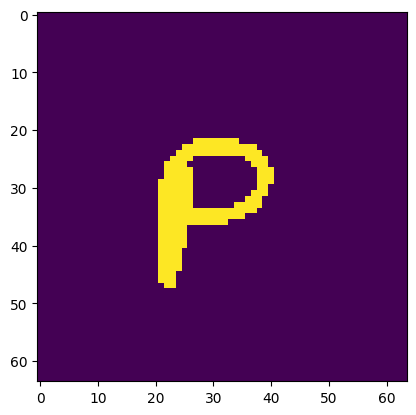

p


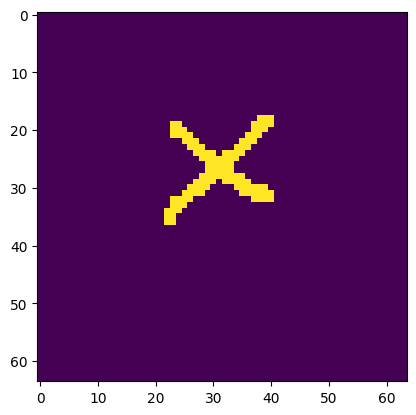

×


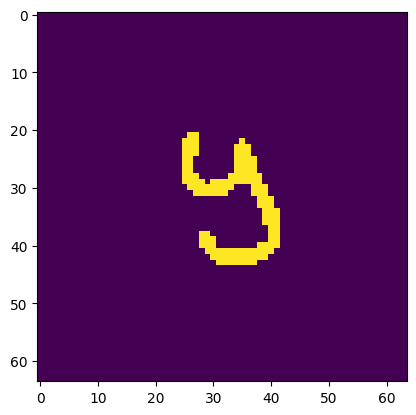

y


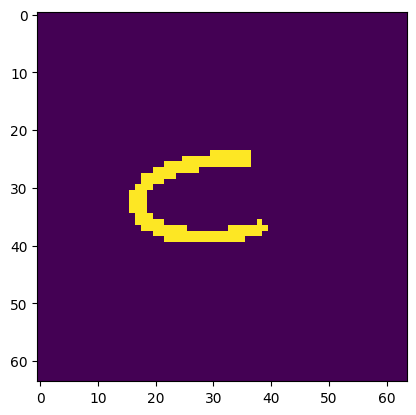

b


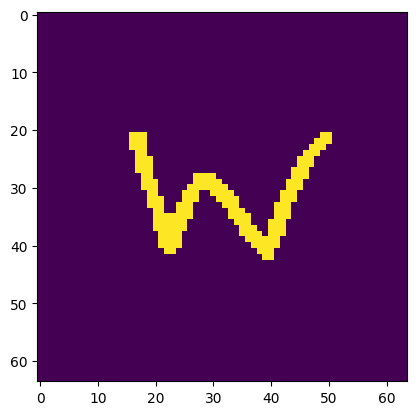

w


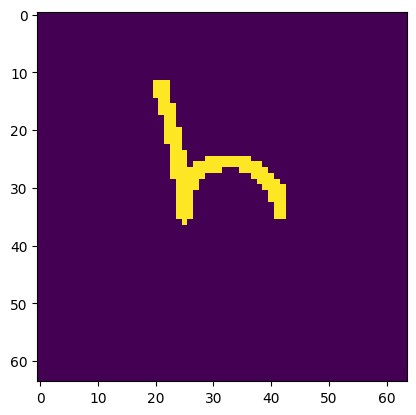

h


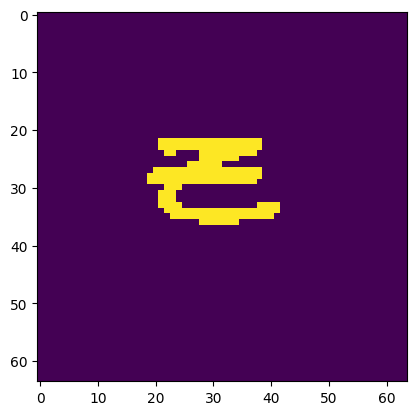

d


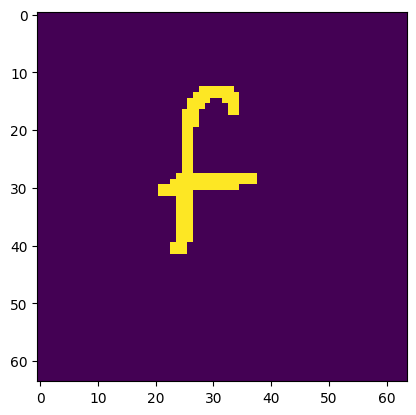

f


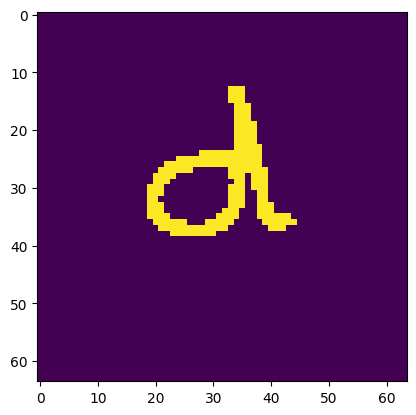

d


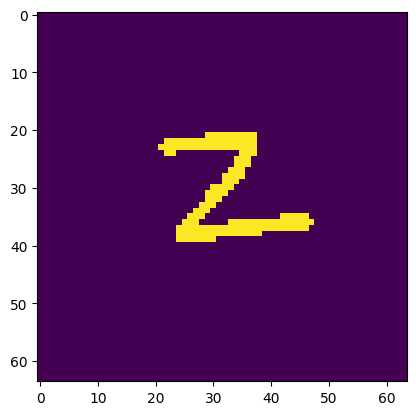

λ


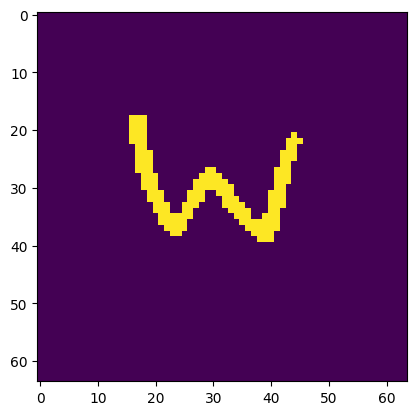

w


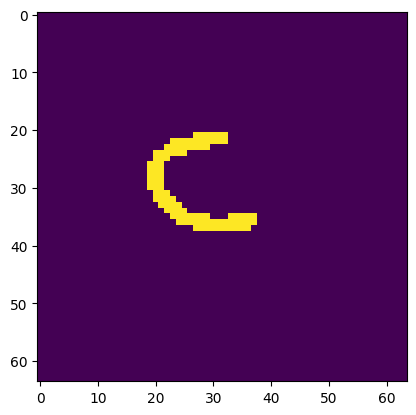

b


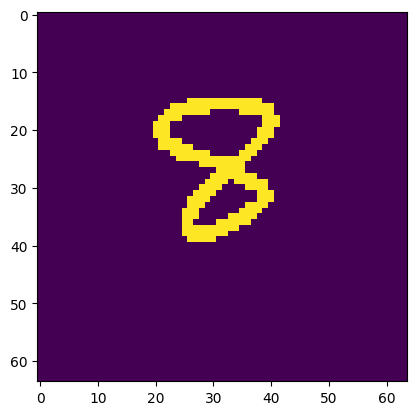

8


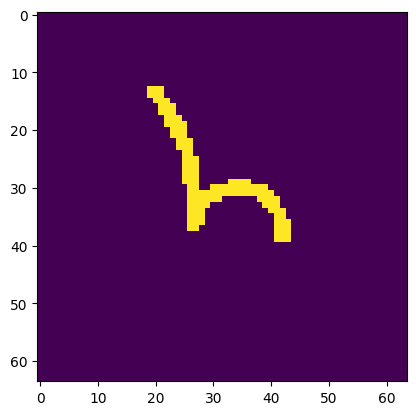

v


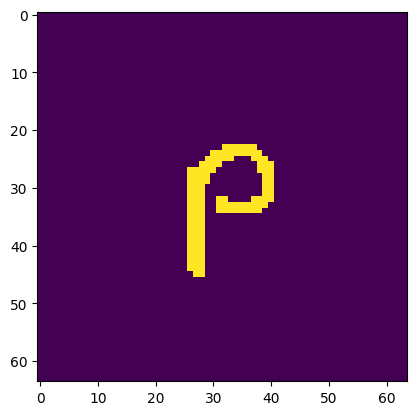

p


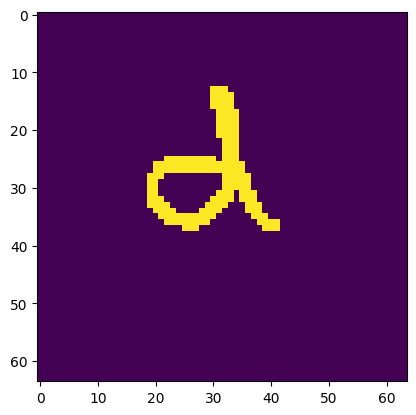

d


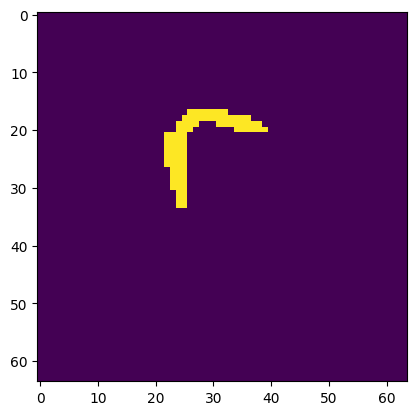

f


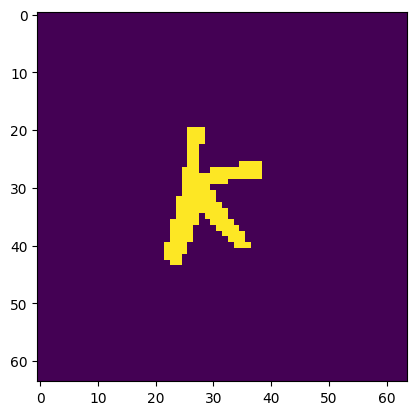

k


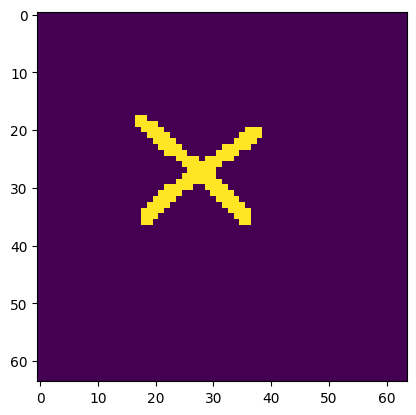

+


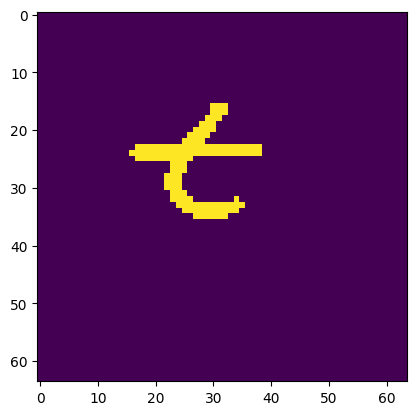

t


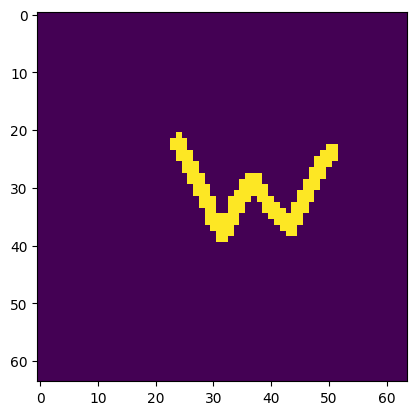

w


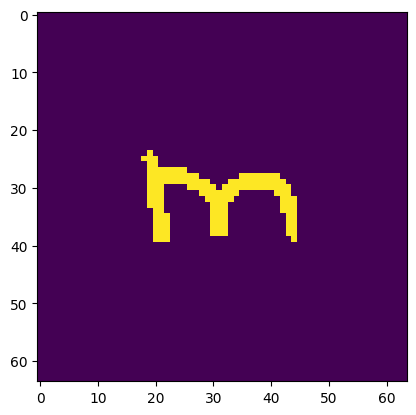

p


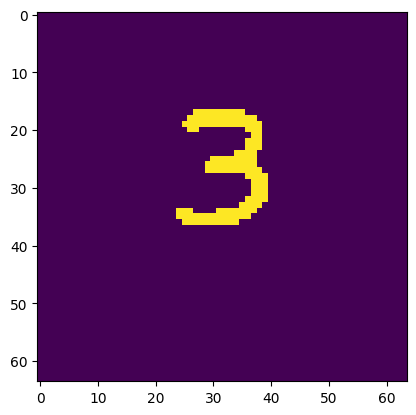

3


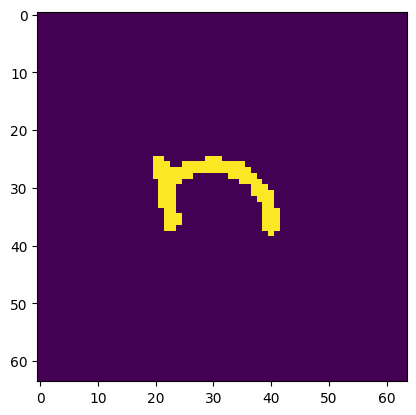

n


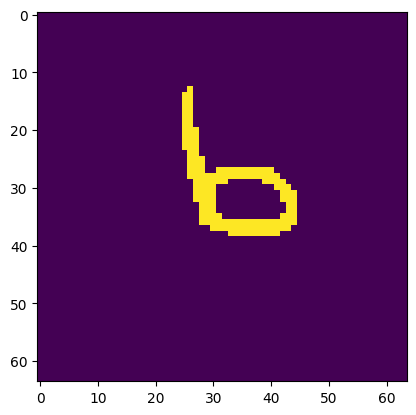

b


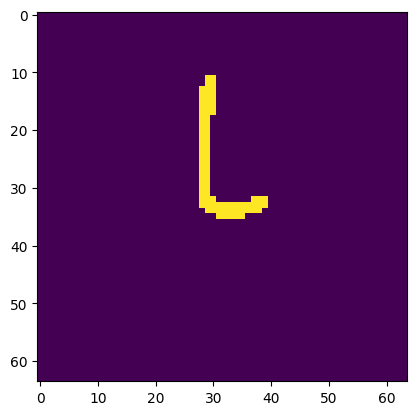

l


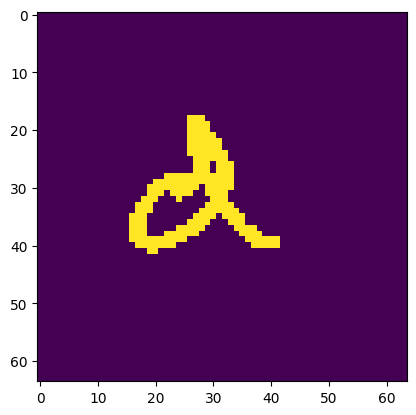

d


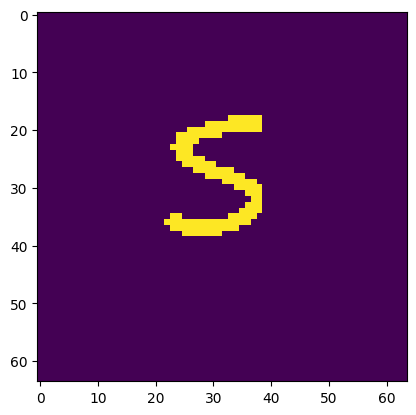

5


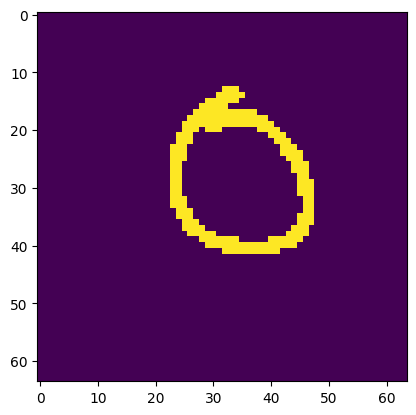

o


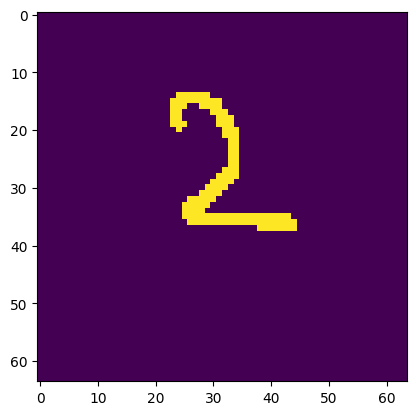

2


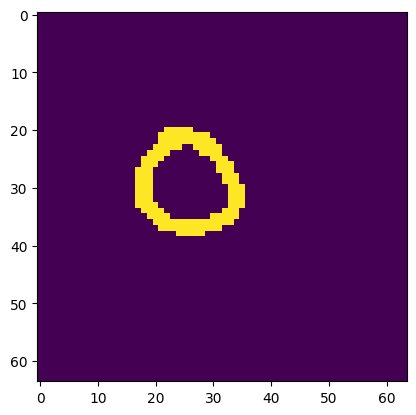

o


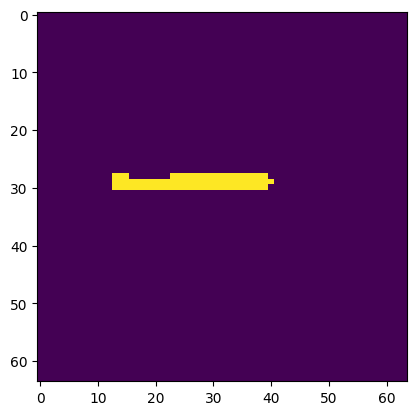

t


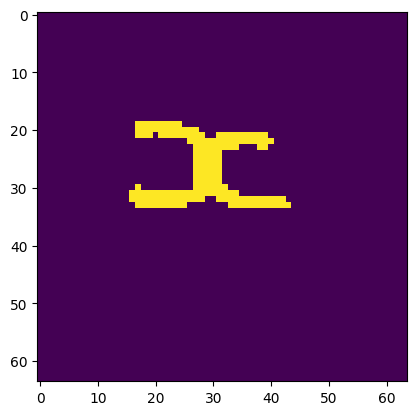

×


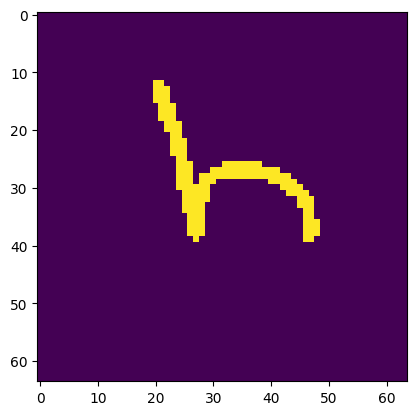

h


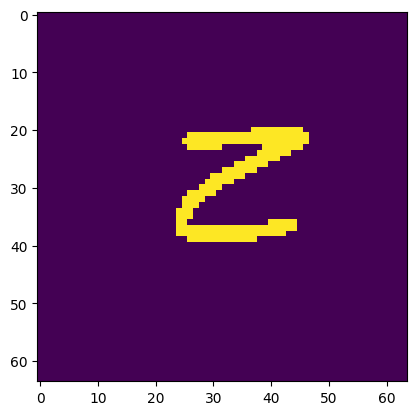

e


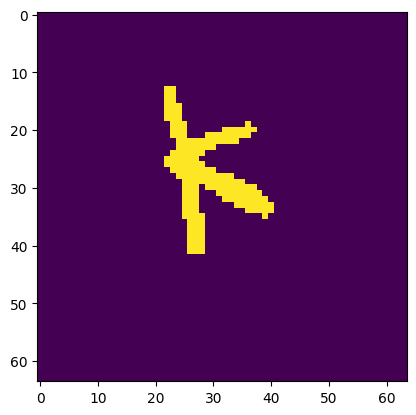

k


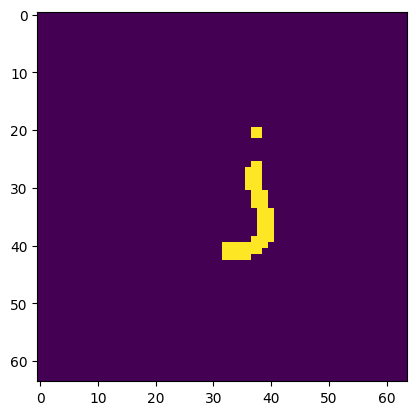

j


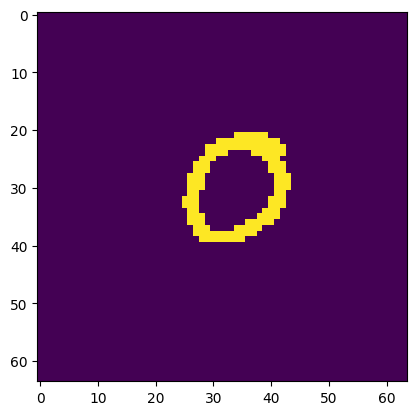

o


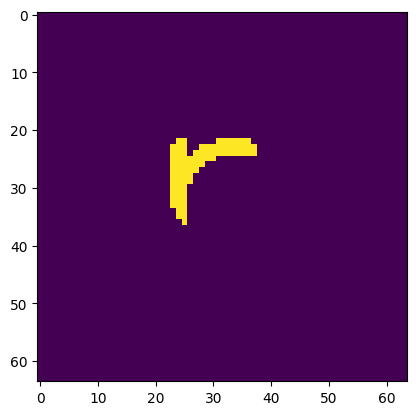

r


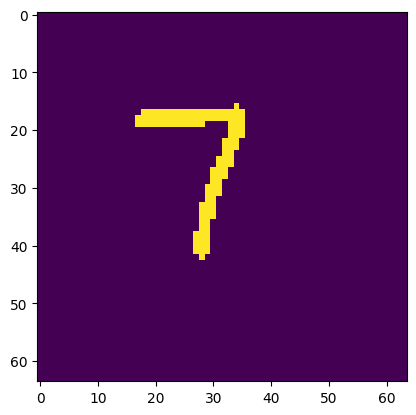

7


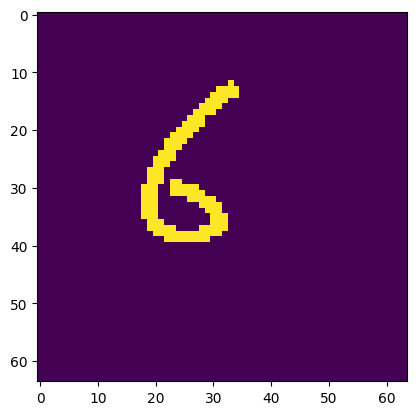

6


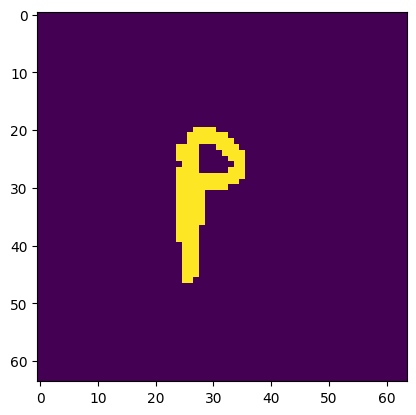

p


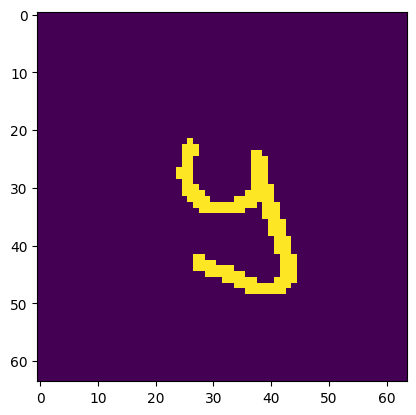

y


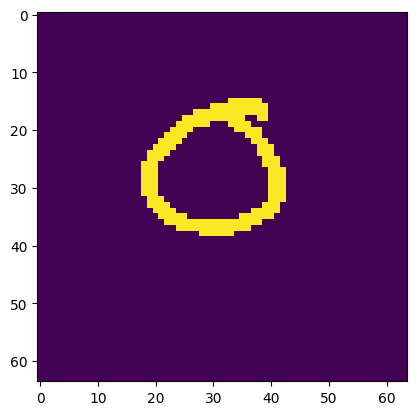

o


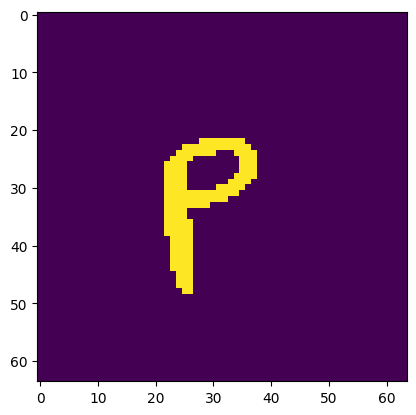

p


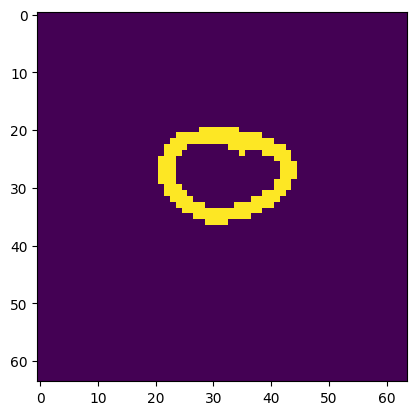

o


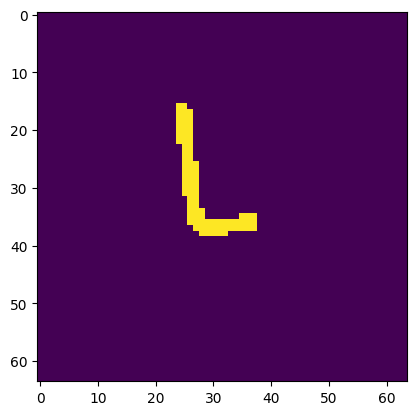

l


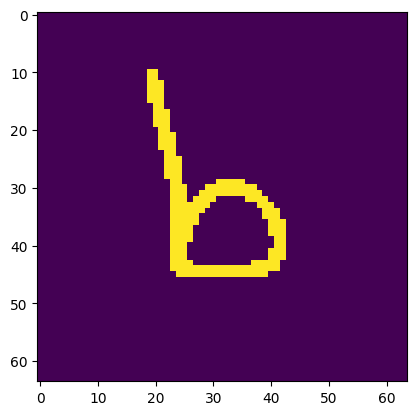

b


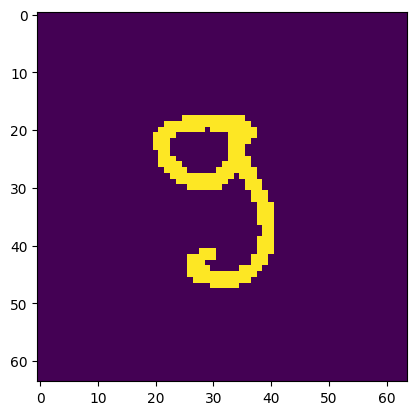

g


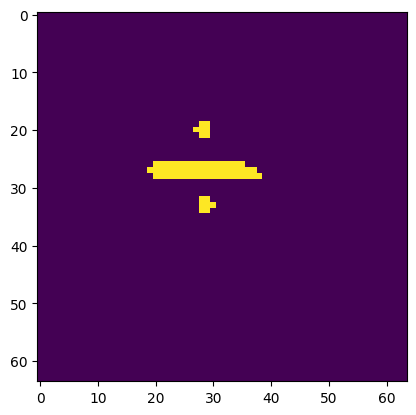

+


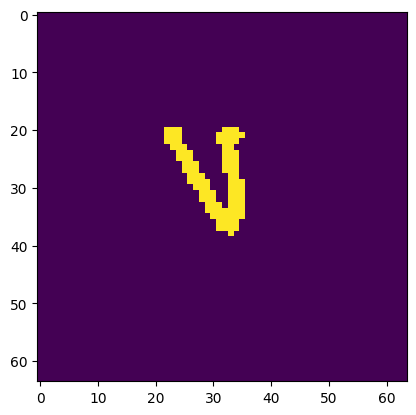

b


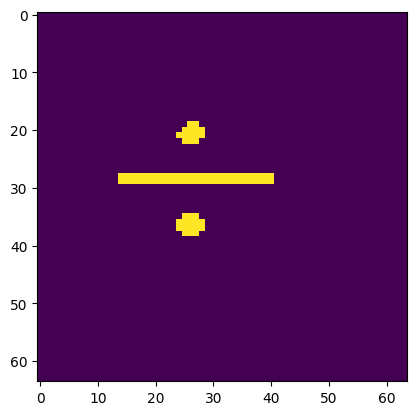

4


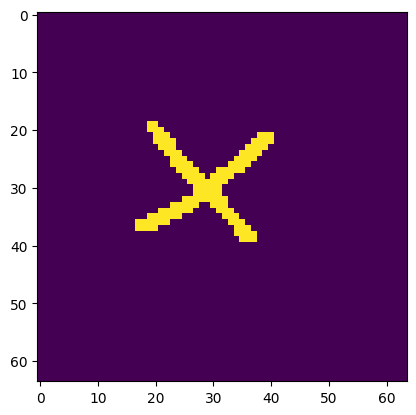

4


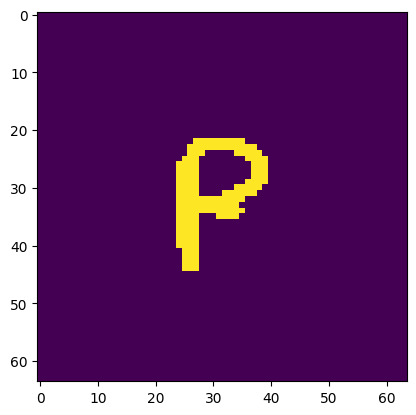

p


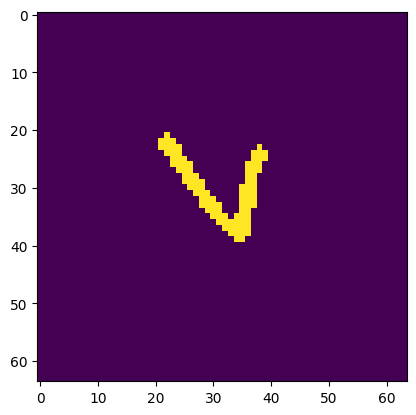

y


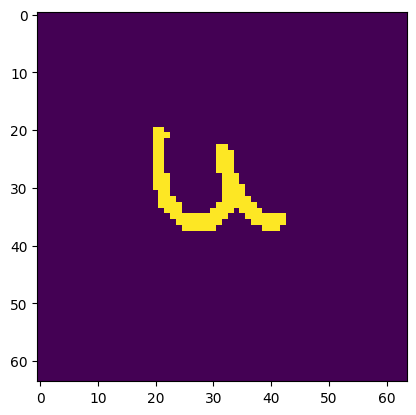

u


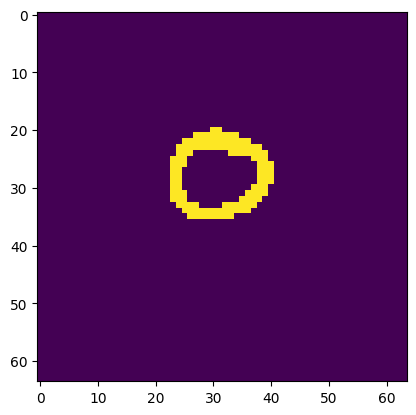

o


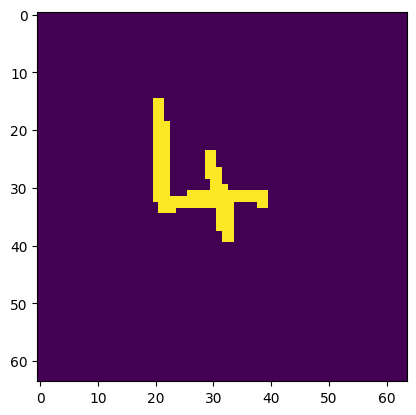

4


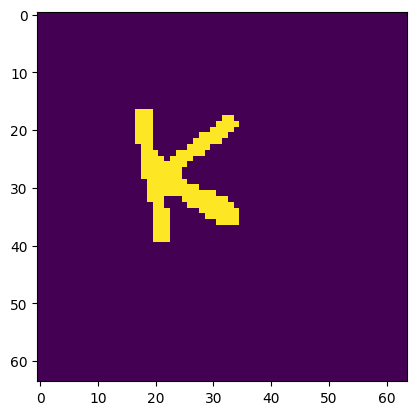

k


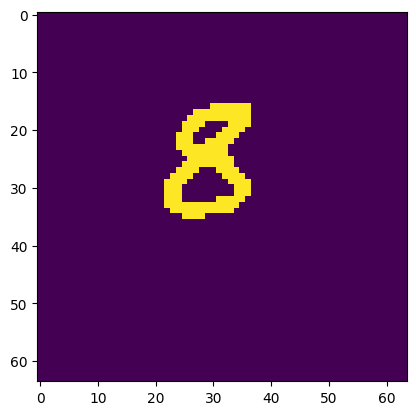

8


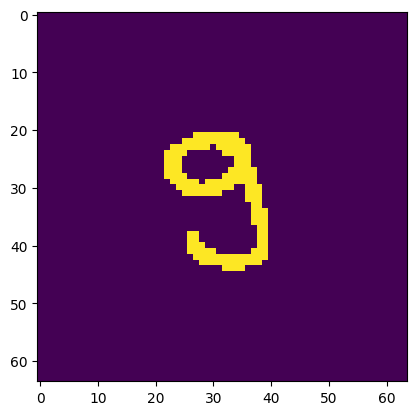

g


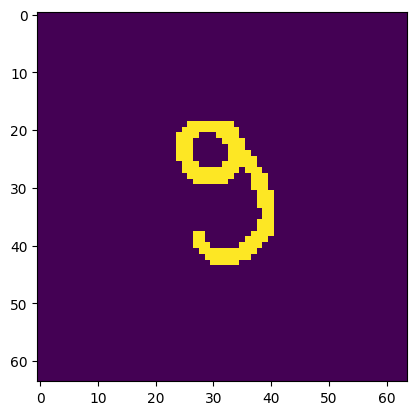

g


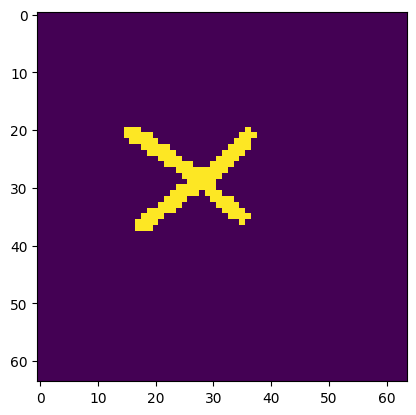

×


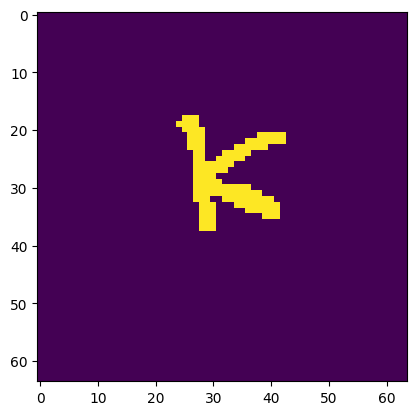

k


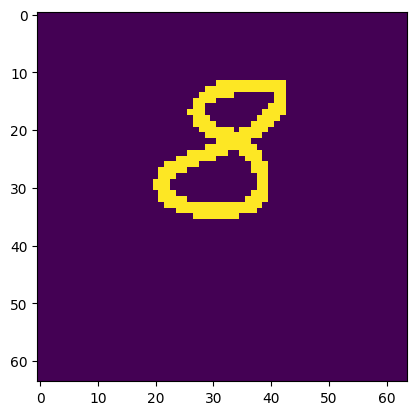

8


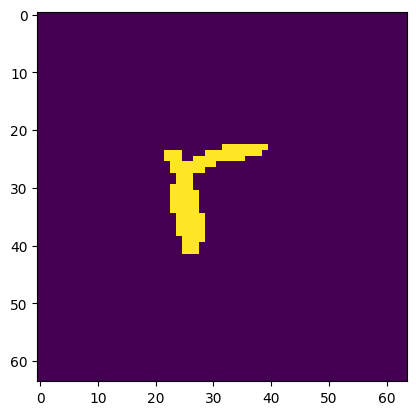

r


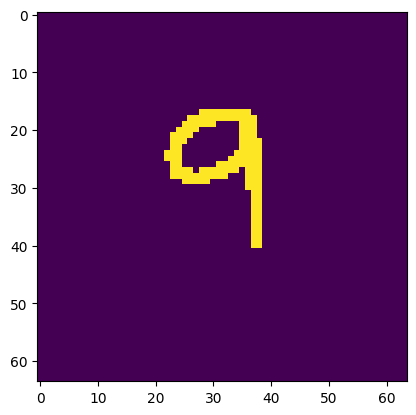

9


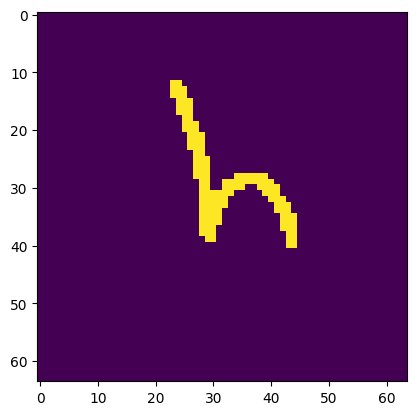

4


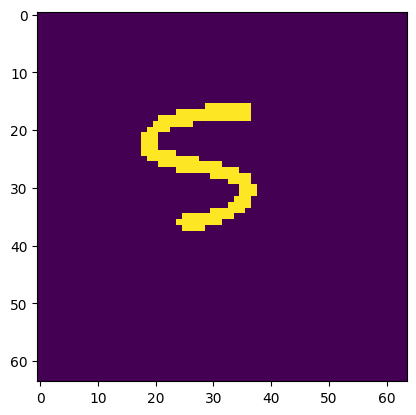

5


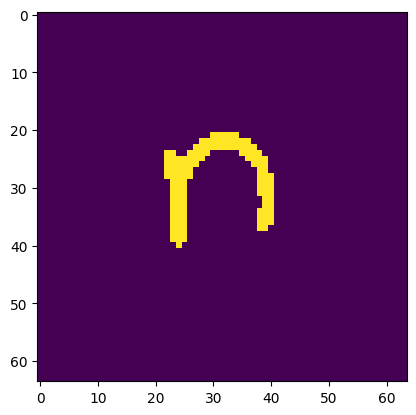

n


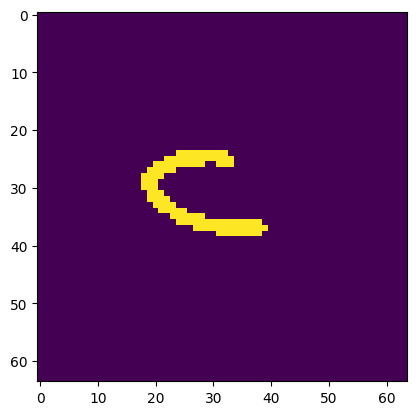

b


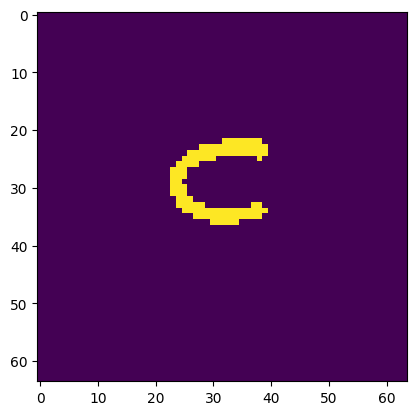

e


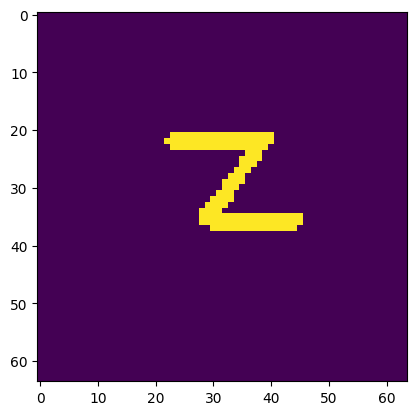

λ


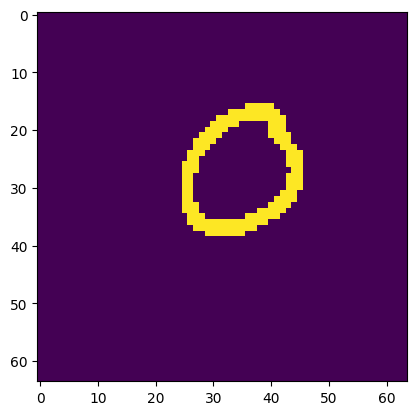

o


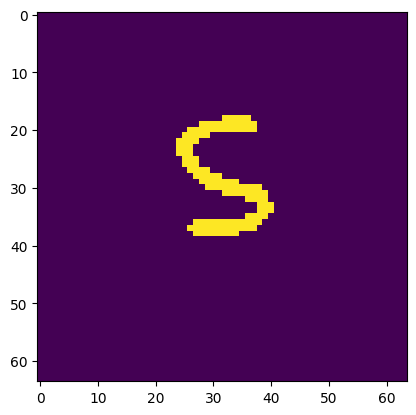

5


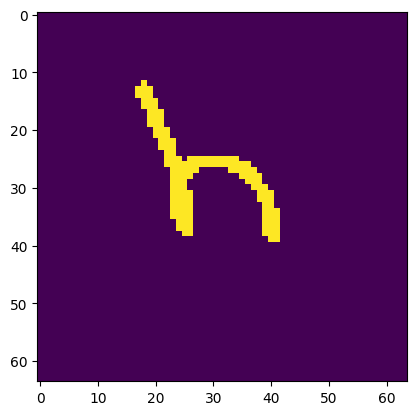

v


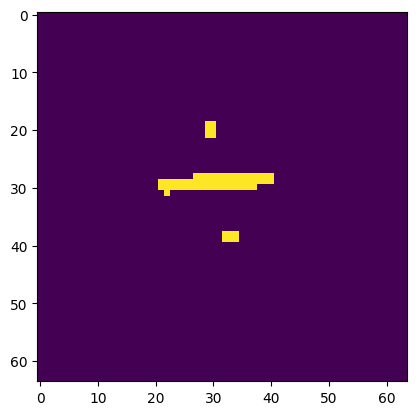

f


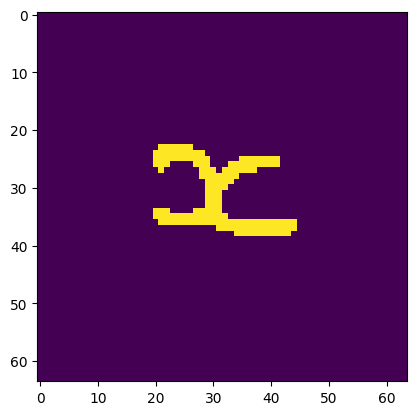

×


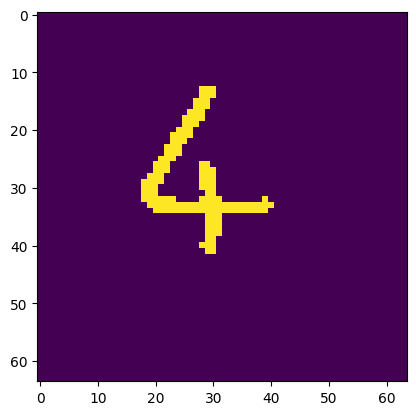

4


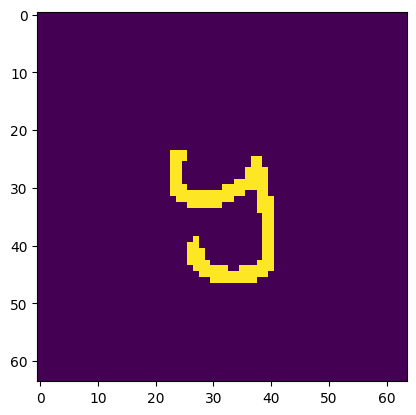

y


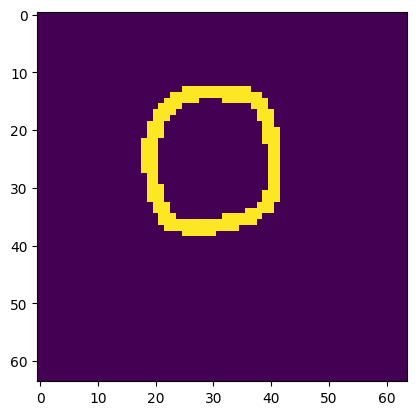

o


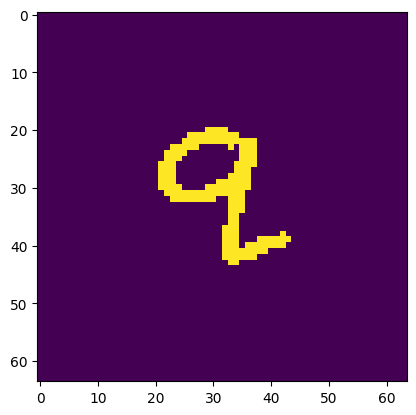

q


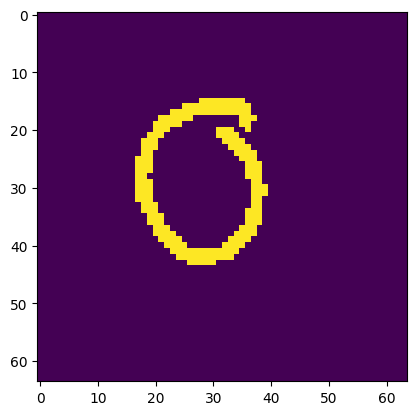

0


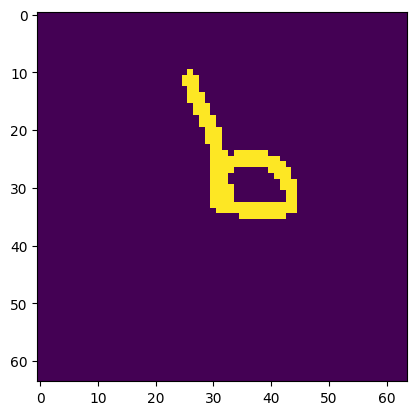

b


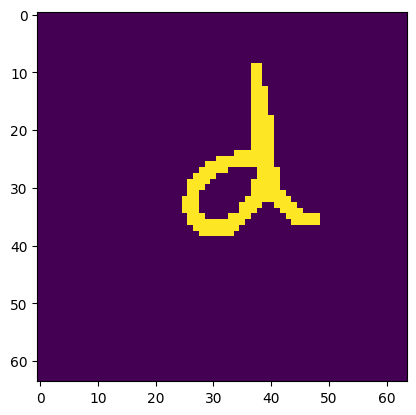

d


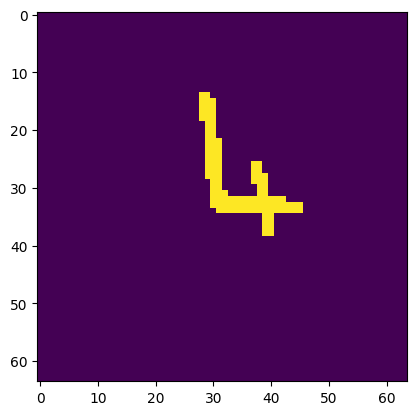

4


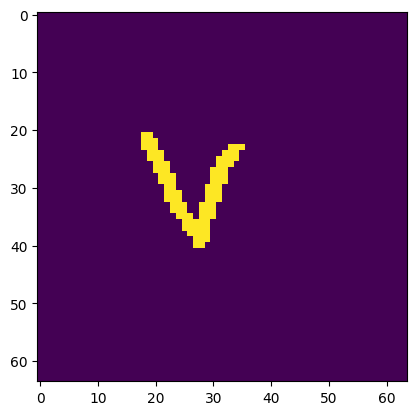

b


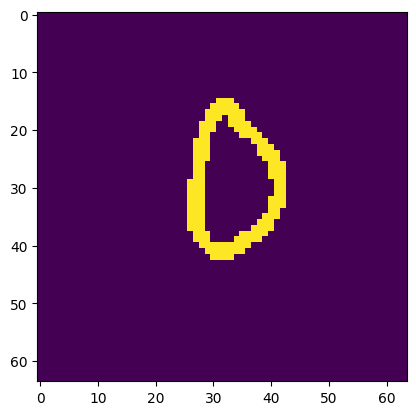

0


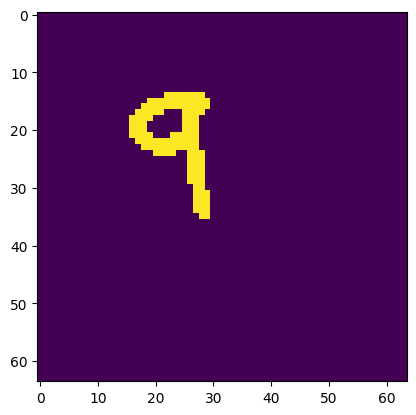

9


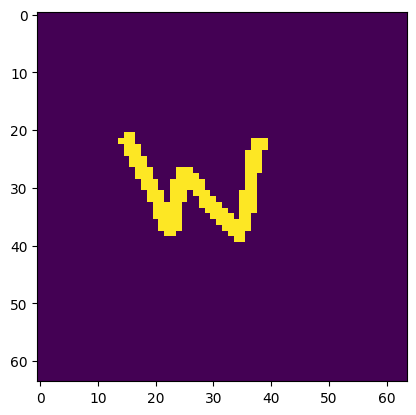

w


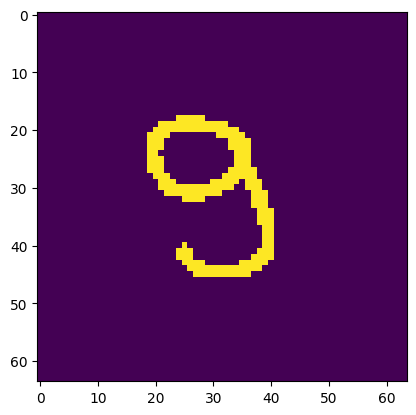

g


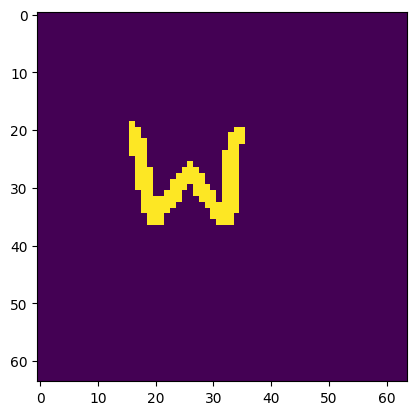

u


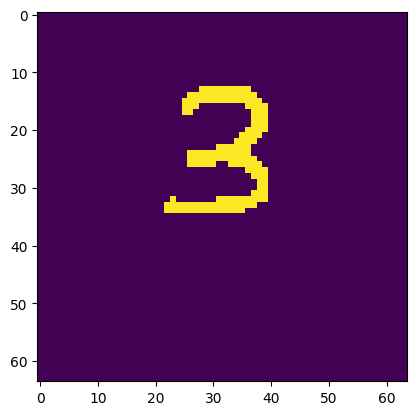

3


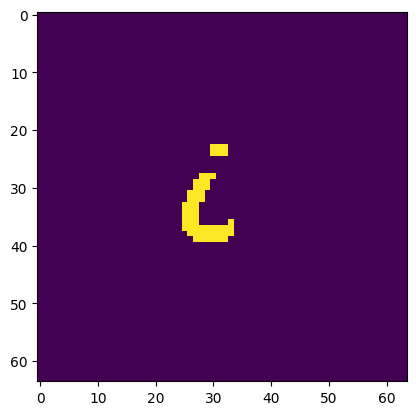

e


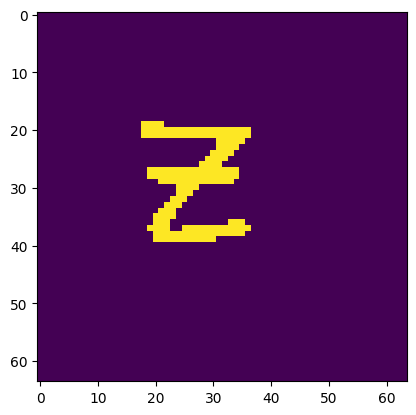

λ


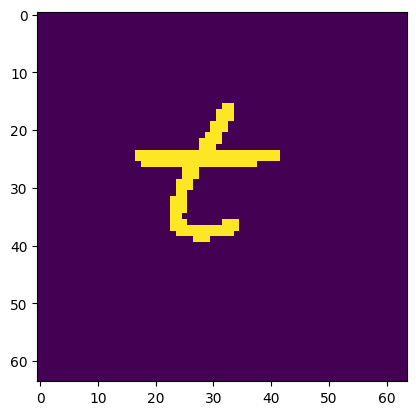

t


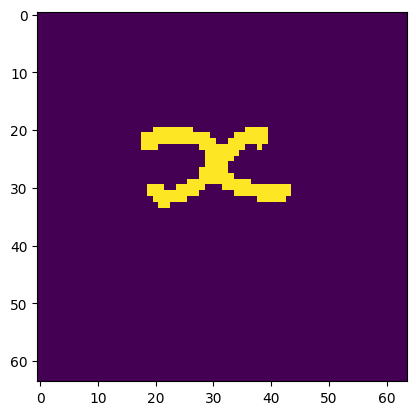

×


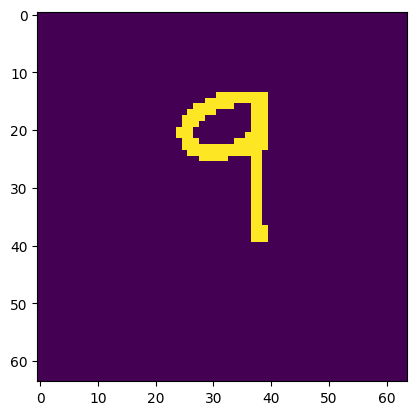

9


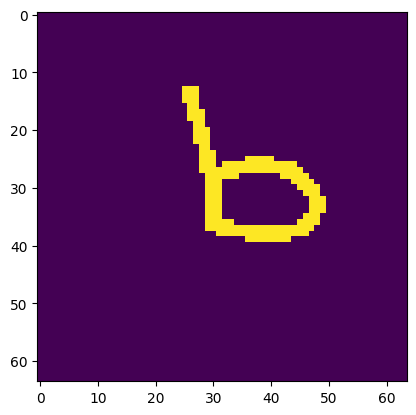

b


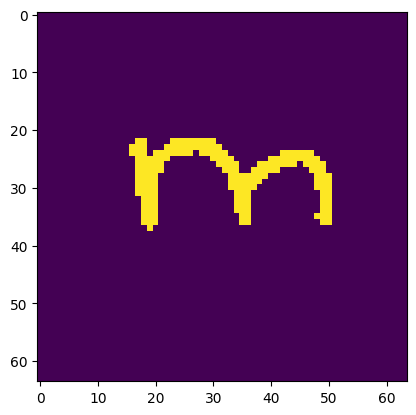

m


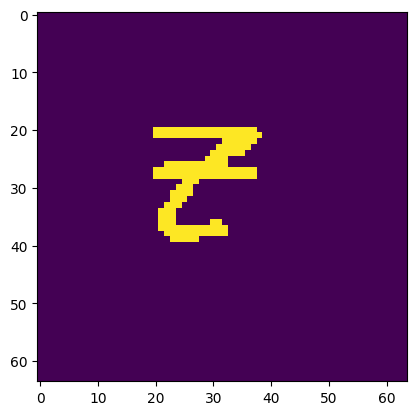

λ


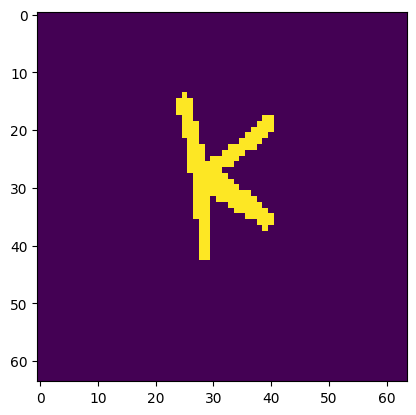

k


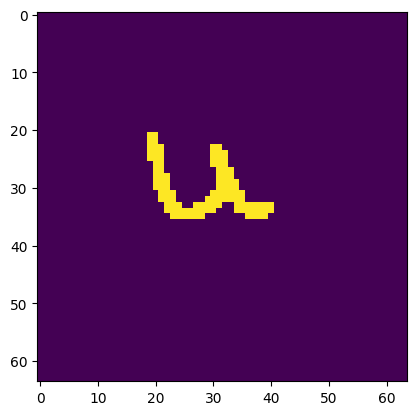

u


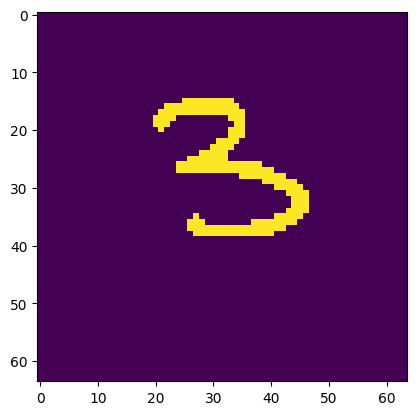

3


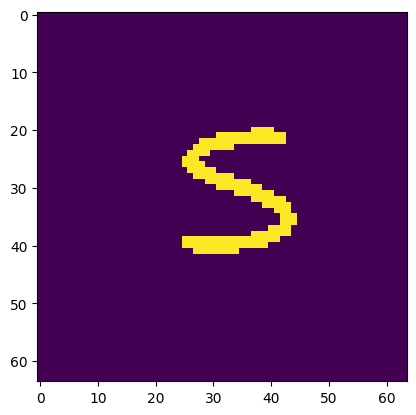

5


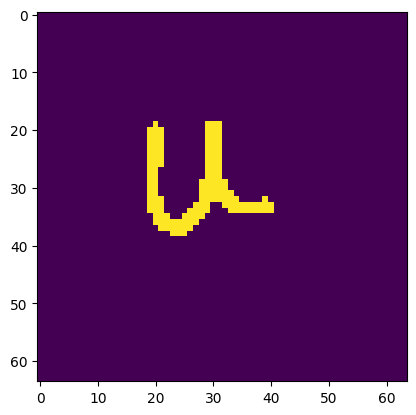

u


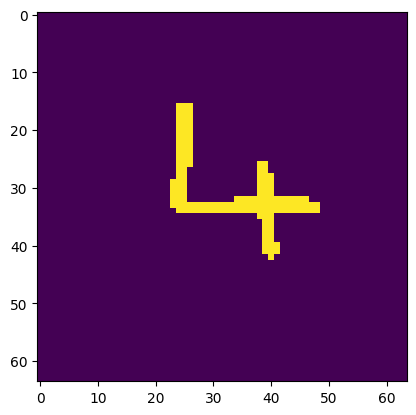

4


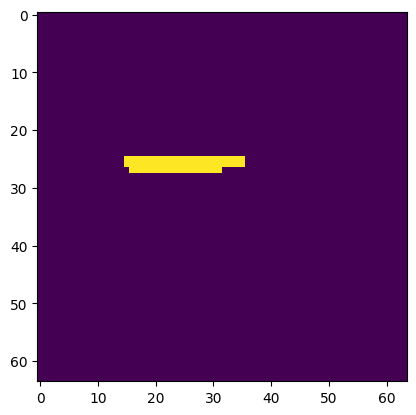

5


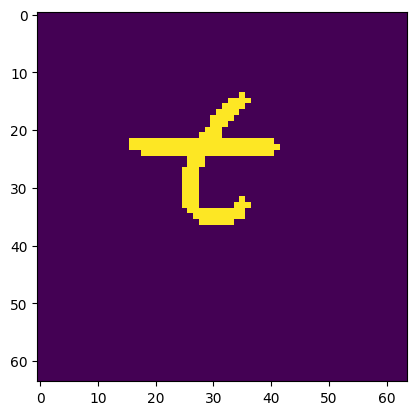

t


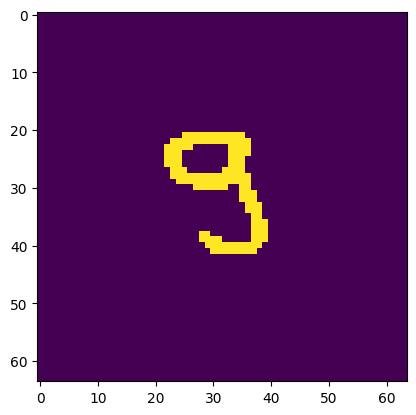

g


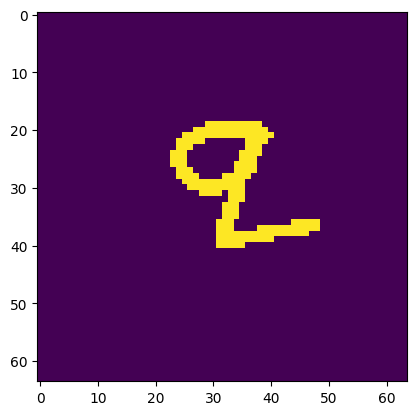

q


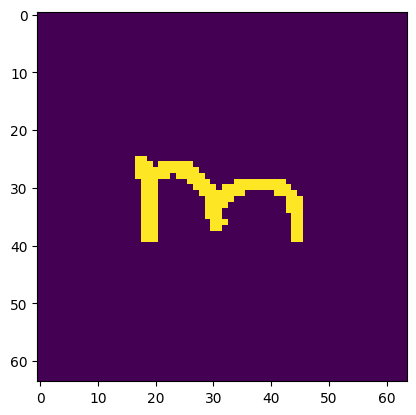

m


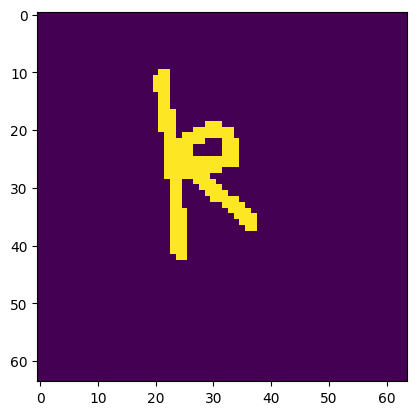

k


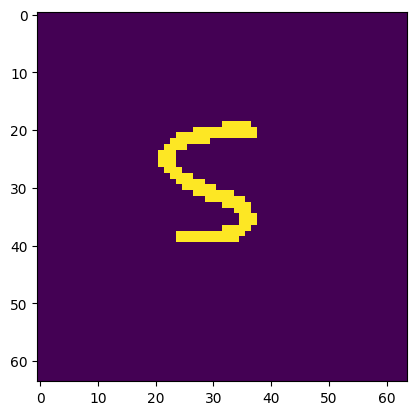

5


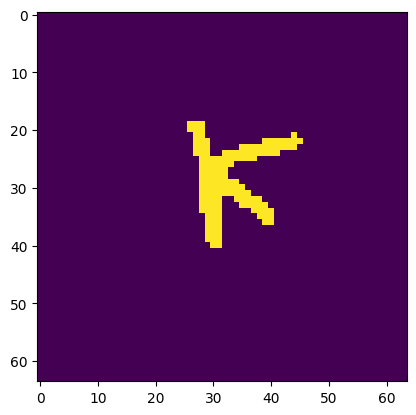

k


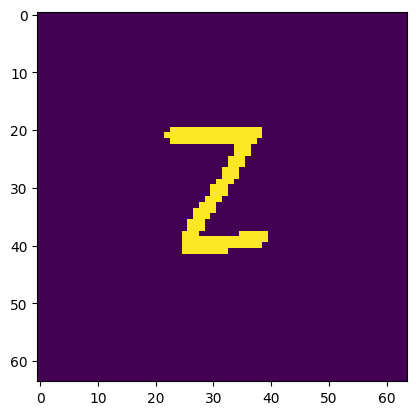

z


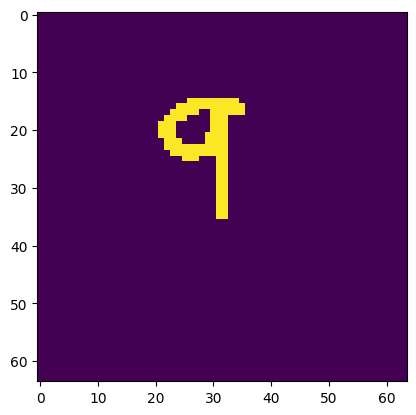

9


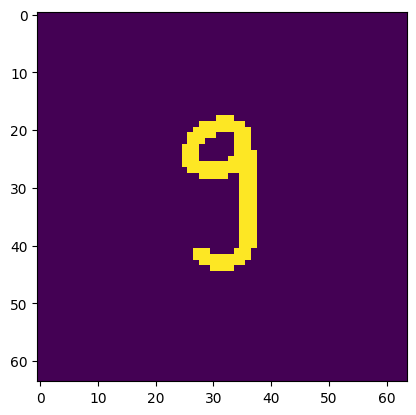

g


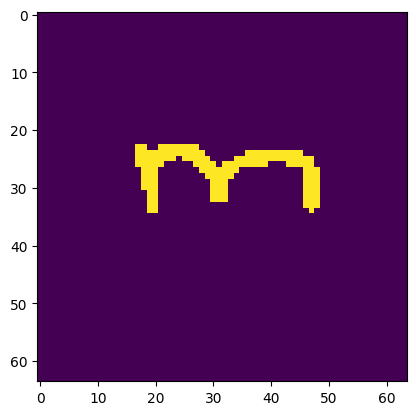

m


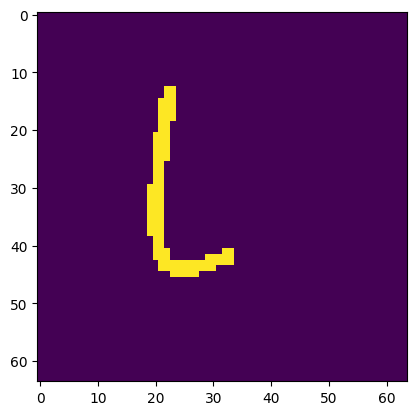

l


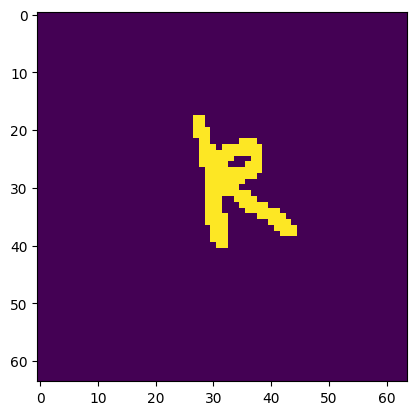

k


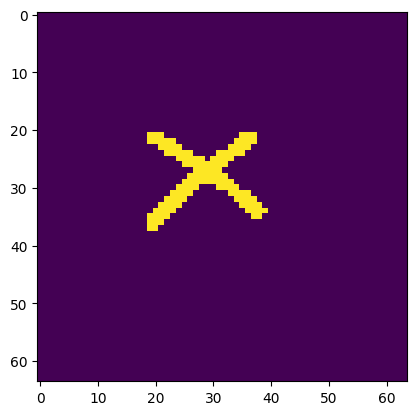

+


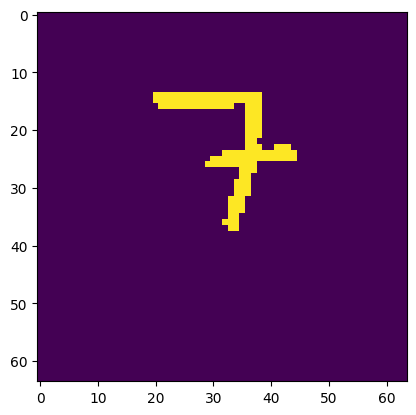

7


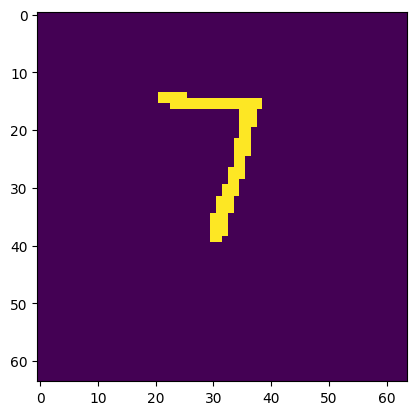

7


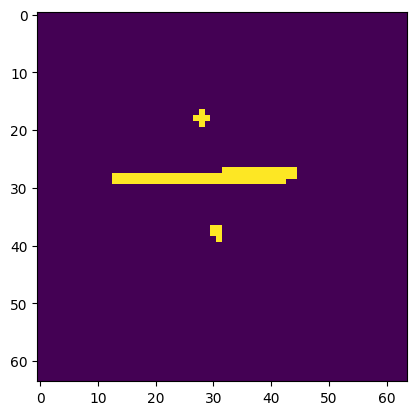

4


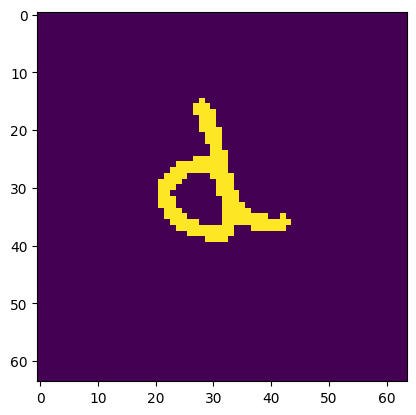

d


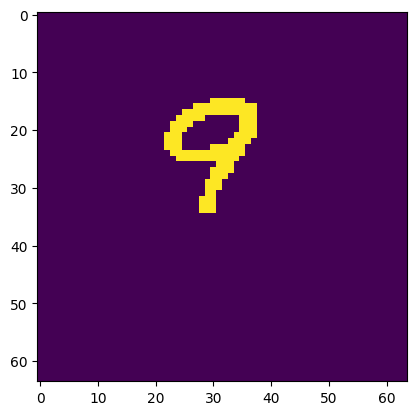

9


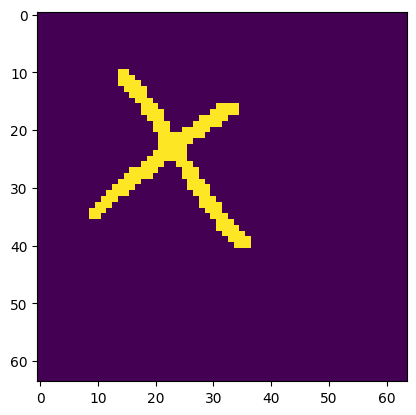

4


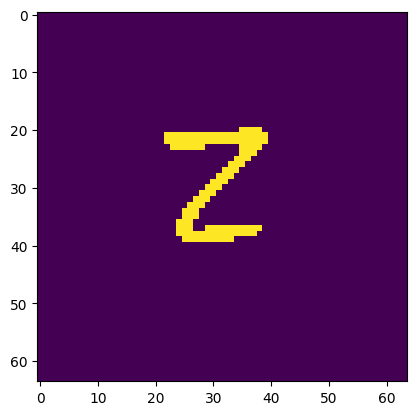

z


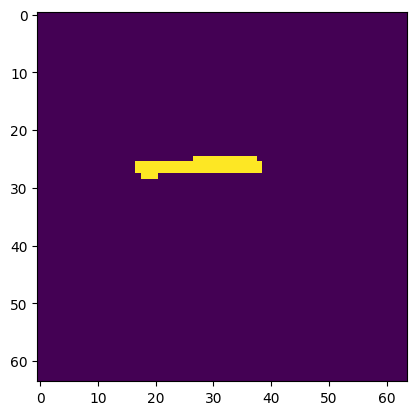

t


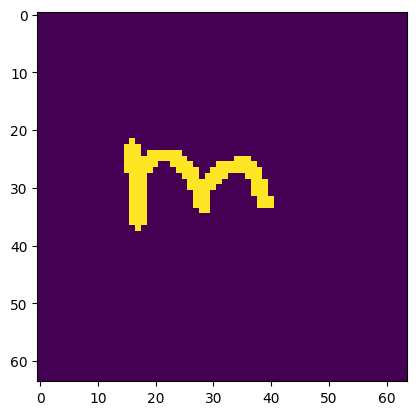

p


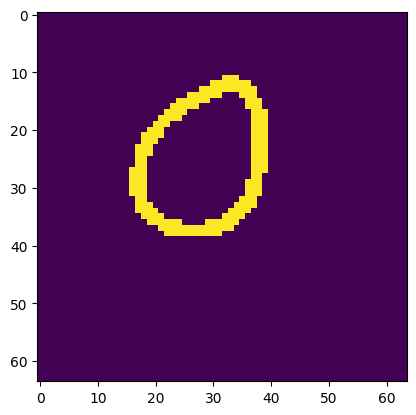

0


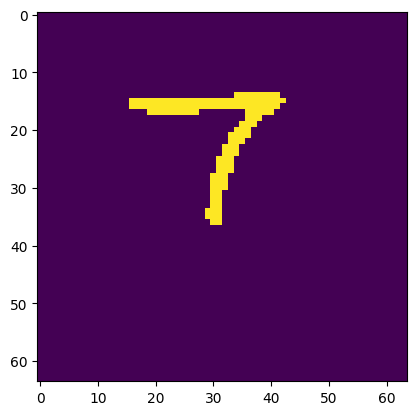

7


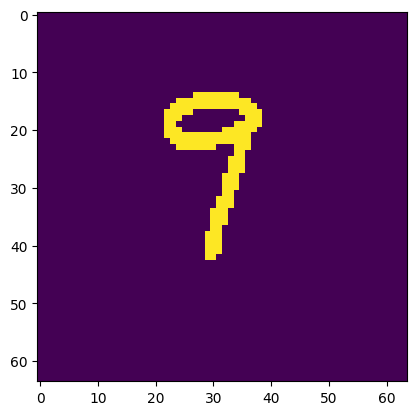

9


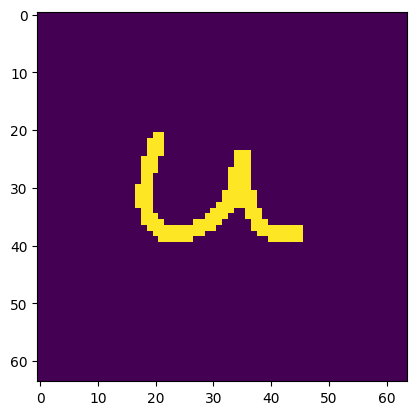

u


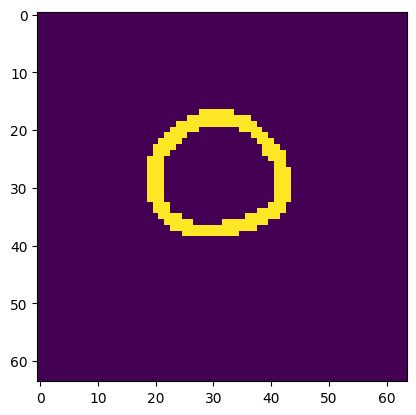

o


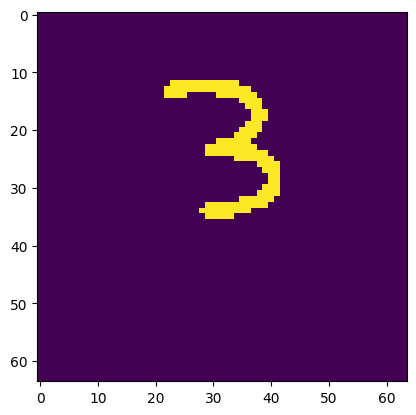

3


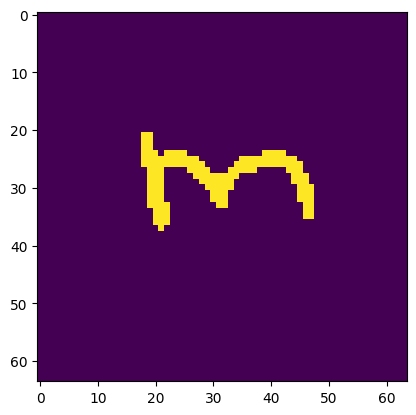

m


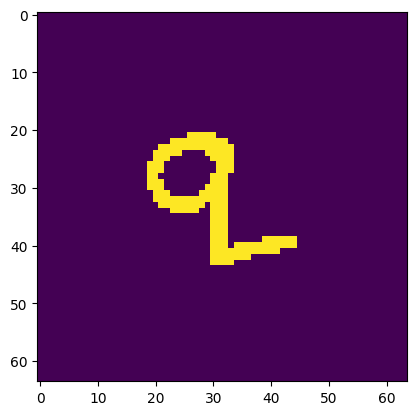

q


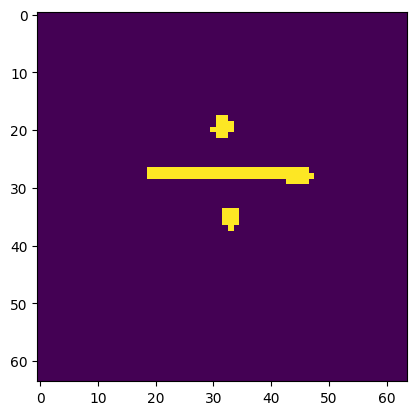

4


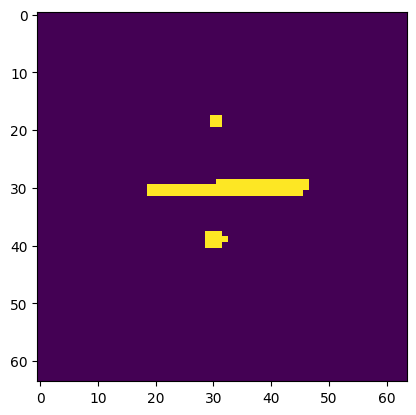

4


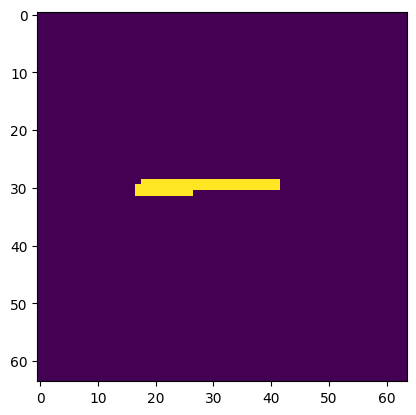

b


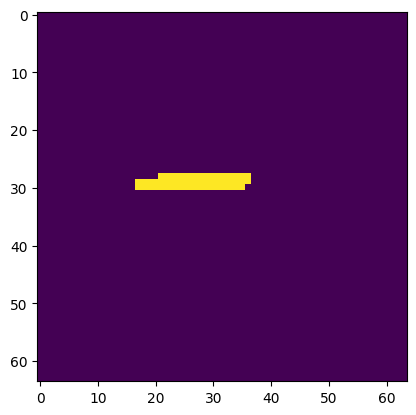

o


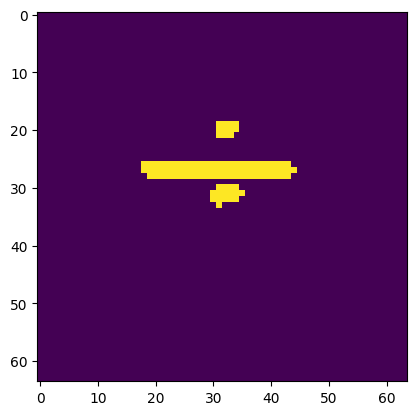

+


In [127]:
for char, label in val_char_dataset:
    plt.imshow(char[0, :, :])
    plt.show()
    pred: torch.Tensor = model.forward(char.unsqueeze(0)).squeeze()
    pred_index: int = torch.argmax(pred).item()
    print(chr(int(all_label_classes[pred_index][1:], base=16)))